In [1]:
#importing all necessary libraries
import os
import re

#importing libraries needed for data analysis
import numpy as np
import pandas as pd

#importing libraries needed for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#libraries used for analysing images
import skimage.io
import skimage.feature
import skimage.transform
from glob import glob

In [2]:
#library used for ML
import sklearn
from sklearn.model_selection import train_test_split

**Load the DATA**

In [3]:
import pickle
data = pickle.load(open('data_animals.pickle','rb'))

In [4]:
x = data['data']
y = data['target']

**Dividing into train and test split**

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=53,stratify=y)

In [6]:
x_train.shape

(1542, 80, 80, 3)

In [7]:
x_test.shape

(515, 80, 80, 3)

# Feature Extraction  **HOG(Histogram of Gradients)**

**Conversion of Images into GRAY**

In [8]:
from sklearn.base import BaseEstimator,TransformerMixin

In [9]:
class RGB2GRAY_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])

In [10]:
rgb2graytransform = RGB2GRAY_Transformer()
x_train_gray = rgb2graytransform.fit_transform(x_train)

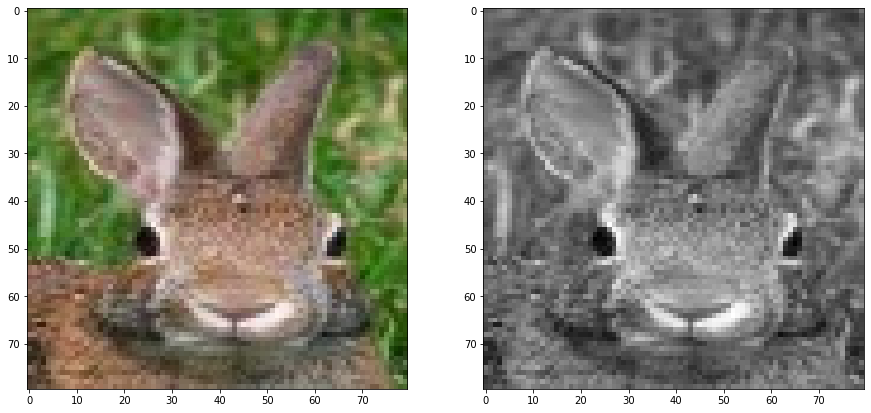

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(x_train[11])
plt.subplot(1,2,2)
plt.imshow(x_train_gray[11],cmap='gray')

**HOG Descriptor**

In [12]:
class HOG_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self,orientations=9,pixels_per_cell=(8,8),cells_per_block=(3,3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        def hog(img):
            features_hog = skimage.feature.hog(img,orientations=self.orientations,pixels_per_cell=self.pixels_per_cell,cells_per_block=self.cells_per_block)
            return features_hog
        hog_features = np.array([hog(x) for x in X])
        return hog_features

In [13]:
hog_transform = HOG_Transformer()
x_train_hog = hog_transform.fit_transform(x_train_gray)

# Classifier

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
model = SGDClassifier()

**Normalization of values**

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_hog)

In [18]:
model.fit(x_train_scaled,y_train)

SGDClassifier()

**Let predict using model built by us**

In [19]:
x_test_gray = rgb2graytransform.fit_transform(x_test)
x_test_hog = hog_transform.fit_transform(x_test_gray)
x_test_scaled = scaler.transform(x_test_hog)

In [20]:
y_pred_test = model.predict(x_test_scaled)

# Model Evaluation

In [21]:
from sklearn.metrics import classification_report

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

        bear       0.80      0.64      0.71        25
         cat       0.82      0.90      0.86        40
     chicken       0.91      0.80      0.85        25
         cow       0.71      0.85      0.77        26
        deer       0.83      0.77      0.80        26
         dog       0.43      0.48      0.46        33
        duck       0.84      0.81      0.82        26
       eagle       0.86      0.76      0.81        25
    elephant       0.83      0.80      0.82        25
       human       0.92      0.96      0.94        25
        lion       0.56      0.80      0.66        25
      monkey       0.80      0.64      0.71        25
       mouse       0.73      0.64      0.68        25
     natural       0.00      0.00      0.00         2
       panda       0.86      0.80      0.83        30
      pigeon       0.72      0.79      0.75        29
      rabbit       0.87      0.52      0.65        25
       sheep       0.62    

**Here the accuracy we got with the default values of hyperparameters is 0.77**
**Lets just apply hyperparameter tuning here**

**Pipeline**

In [24]:
from sklearn.pipeline import Pipeline

In [25]:
pipeline_of_model = Pipeline([('rgb2gray',RGB2GRAY_Transformer()),
                              ('hog_transform',HOG_Transformer(orientations=9,pixels_per_cell=(8,8),cells_per_block=(3,3))),
                              ('standardscaler',StandardScaler()),
                              ('sgd_model',SGDClassifier())
                             ])

In [26]:
pipeline_of_model.fit(x_train,y_train)

Pipeline(steps=[('rgb2gray', RGB2GRAY_Transformer()),
                ('hog_transform', HOG_Transformer()),
                ('standardscaler', StandardScaler()),
                ('sgd_model', SGDClassifier())])

In [27]:
y_pred_test = pipeline_of_model.predict(x_test)

In [28]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

        bear       0.80      0.64      0.71        25
         cat       0.88      0.93      0.90        40
     chicken       0.91      0.84      0.87        25
         cow       0.75      0.92      0.83        26
        deer       0.86      0.69      0.77        26
         dog       0.51      0.55      0.53        33
        duck       0.92      0.88      0.90        26
       eagle       0.79      0.76      0.78        25
    elephant       0.81      0.84      0.82        25
       human       0.96      1.00      0.98        25
        lion       0.59      0.88      0.71        25
      monkey       0.78      0.56      0.65        25
       mouse       0.76      0.76      0.76        25
     natural       0.00      0.00      0.00         2
       panda       0.96      0.90      0.93        30
      pigeon       0.76      0.90      0.83        29
      rabbit       0.75      0.60      0.67        25
       sheep       0.76    

# HyperParameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
pipeline_of_model = Pipeline([('rgb2gray',RGB2GRAY_Transformer()),
                              ('hog_transform',HOG_Transformer()),
                              ('standardscaler',StandardScaler()),
                              ('sgd_model',SGDClassifier())
                             ])

In [31]:
parameters = [
    {
        'hog_transform__orientations':[7,8,9,10],
        'hog_transform__pixels_per_cell':[(8,8),(9,9),(10,10)],
        'hog_transform__cells_per_block':[(2,2),(3,3)],
        'sgd_model__loss':[ 'hinge', 'squared_hinge', 'perceptron'],
        'sgd_model__learning_rate':['optimal']
    },
    {
        'hog_transform__orientations':[7,8,9,10],
        'hog_transform__pixels_per_cell':[(8,8),(9,9),(10,10)],
        'hog_transform__cells_per_block':[(2,2),(3,3)],
        'sgd_model__loss':[ 'hinge','squared_hinge', 'perceptron'],
        'sgd_model__learning_rate':['adaptive'],
        'sgd_model__eta0':[0.001,0.01,0.02]
    }
]

In [32]:
model_hyperparameter_tuning = GridSearchCV(estimator=pipeline_of_model,param_grid=parameters,scoring='accuracy',verbose=1.5,n_jobs=1,cv=3)

In [33]:
model_hyperparameter_tuning.fit(x_train,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   7.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   6.8s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   6.8s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   6.9s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, s

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   5.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   5.0s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   4.9s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   5.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   5.2s
[CV] 

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   8.6s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   8.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   9.0s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   8.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   8

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   5.3s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   6.3s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   6.6s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   6.1s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   6.0s
[CV] END 

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   8.5s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   8.1s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   7.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total time=   8.2s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(9, 9), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   5.2s
[CV] EN

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=hinge; total time=   6.2s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   5.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   5.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=squared_hinge; total time=   6.0s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__learning_rate=optimal, sgd_model__loss=perceptron; total

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   6.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   6.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   6.0s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   5.5s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_p

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   7.4s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   7.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   7.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   7.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=7, hog_transform__pixels_

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  12.7s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  12.6s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  13.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   7.9s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9)

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   7.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   7.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   7.8s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   7.4s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=8, hog_transform__pixels_per_cell=(1

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  12.6s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  13.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  12.9s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  13.0s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   8.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   8.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   7.8s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   7.9s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(1

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  23.5s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  23.5s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  23.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  23.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(

[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  14.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  14.9s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  15.3s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  15.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=10, hog_transform__pixels_pe

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  18.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  18.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  18.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  19.6s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixel

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   5.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   6.0s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   5.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=   5.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_c

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  13.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  14.0s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  13.7s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=7, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  13.7s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  12.4s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  12.5s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  12.4s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  14.2s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(9, 

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  15.5s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  14.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  16.5s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  16.6s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=8, hog_transform__pixels_per_cell=(10,

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=perceptron; total time=  28.3s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  14.3s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  14.4s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(9, 9), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  14.3s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(9, 9), sgd_mo

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  15.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  16.4s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  16.0s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.01, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  15.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=9, hog_transform__pixels_per_cell=(10, 1

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  22.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=  21.7s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  19.1s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), sgd_model__eta0=0.02, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=  19.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=hinge; total time=   9.5s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   8.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   8.4s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(10, 10), sgd_model__eta0=0.001, sgd_model__learning_rate=adaptive, sgd_model__loss=squared_hinge; total time=   8.5s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transfor

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rgb2gray', RGB2GRAY_Transformer()),
                                       ('hog_transform', HOG_Transformer()),
                                       ('standardscaler', StandardScaler()),
                                       ('sgd_model', SGDClassifier())]),
             n_jobs=1,
             param_grid=[{'hog_transform__cells_per_block': [(2, 2), (3, 3)],
                          'hog_transform__orientations': [7, 8, 9, 10],
                          'hog_transform__pixels_per_cell': [(8, 8), (9, 9),
                                                             (10, 10)],
                          '...
                          'sgd_model__loss': ['hinge', 'squared_hinge',
                                              'perceptron']},
                         {'hog_transform__cells_per_block': [(2, 2), (3, 3)],
                          'hog_transform__orientations': [7, 8, 9, 10],
                          'hog_transform

In [34]:
model_hyperparameter_tuning.best_params_

{'hog_transform__cells_per_block': (2, 2),
 'hog_transform__orientations': 8,
 'hog_transform__pixels_per_cell': (8, 8),
 'sgd_model__learning_rate': 'optimal',
 'sgd_model__loss': 'squared_hinge'}

In [35]:
best_model = model_hyperparameter_tuning.best_estimator_
best_model

Pipeline(steps=[('rgb2gray', RGB2GRAY_Transformer()),
                ('hog_transform',
                 HOG_Transformer(cells_per_block=(2, 2), orientations=8)),
                ('standardscaler', StandardScaler()),
                ('sgd_model', SGDClassifier(loss='squared_hinge'))])

In [36]:
y_pred_test = best_model.predict(x_test)

In [37]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

        bear       0.68      0.68      0.68        25
         cat       0.83      0.88      0.85        40
     chicken       0.84      0.84      0.84        25
         cow       0.70      0.73      0.72        26
        deer       0.78      0.69      0.73        26
         dog       0.46      0.52      0.49        33
        duck       0.72      0.81      0.76        26
       eagle       0.76      0.64      0.70        25
    elephant       0.88      0.88      0.88        25
       human       0.93      1.00      0.96        25
        lion       0.50      0.64      0.56        25
      monkey       0.89      0.68      0.77        25
       mouse       0.68      0.76      0.72        25
     natural       0.00      0.00      0.00         2
       panda       0.96      0.87      0.91        30
      pigeon       0.76      0.76      0.76        29
      rabbit       0.83      0.60      0.70        25
       sheep       0.56    

In [38]:
pickle.dump(best_model,open('best_model.pickle','wb'))

**We can clearly observe that the model with default are the best**

In [39]:
pickle.dump(pipeline_of_model,open('model.pickle','wb'))

In [51]:
from sklearn.pipeline import make_pipeline
pipeline1 = make_pipeline(RGB2GRAY_Transformer(),HOG_Transformer())
features = pipeline1.fit_transform(x_train)
scalar = StandardScaler()
transformed_xtrain = scalar.fit_transform(features)

In [52]:
model = SGDClassifier()
model.fit(transformed_xtrain,y_train)

SGDClassifier()

In [53]:
features = pipeline1.fit_transform(x_test)
transformed_x = scalar.transform(features)
y_pred_test = model.predict(transformed_x)
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

        bear       0.81      0.68      0.74        25
         cat       0.82      0.93      0.87        40
     chicken       0.88      0.84      0.86        25
         cow       0.68      0.88      0.77        26
        deer       0.83      0.73      0.78        26
         dog       0.51      0.58      0.54        33
        duck       0.92      0.85      0.88        26
       eagle       0.83      0.76      0.79        25
    elephant       0.74      0.80      0.77        25
       human       0.92      0.96      0.94        25
        lion       0.54      0.84      0.66        25
      monkey       0.89      0.64      0.74        25
       mouse       0.71      0.68      0.69        25
     natural       0.00      0.00      0.00         2
       panda       0.93      0.87      0.90        30
      pigeon       0.79      0.90      0.84        29
      rabbit       0.88      0.60      0.71        25
       sheep       0.68    

In [54]:
pickle.dump(model,open('Image_Classification.pickle','wb'))

In [55]:
pickle.dump(scalar,open('Scaler.pickle','wb'))